# Gold nanoparticle reconstruction with direct methods in quantem 

Notebook from Georgios Varnavides and Stephanie Ribet

Data collected by Stephanie Ribet, TEAM I, Jan 2025

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import numpy as np

import quantem as em
from quantem.core import config
from quantem.core.visualization import show_2d

config.set_device(0)
print(config.get("device"))

/Users/macbook/miniforge3/envs/qt-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mps


# load data

In [3]:
file_data = '/Users/macbook/data/ptycho_gold_data_2024.h5'
dc = em.io.read_emdfile_to_4dstem(
    file_data, 
    data_keys=["py4DSTEM_root", "datacube", "data"],
    calibration_keys=["py4DSTEM_root", "metadatabundle", "calibration"]
)

print(dc)

keys:  ['py4DSTEM_root', 'datacube', 'data']
quantem Dataset named '4D-STEM dataset'
  shape: (48, 48, 192, 192)
  dtype: float32
  device: cpu
  origin: [0. 0. 0. 0.]
  sampling: [2.38888889 2.38888889 0.45953145 0.45953145]
  units: ["b'A'", "b'A'", "b'mrad'", "b'mrad'"]
  signal units: 'arb. units'


In [4]:
# calibrations
PROBE_SEMIANGLE = 21.9
ENERGY = 300e3
SCAN_WIDTH = dc.array.shape[0]
FOV = 340 #A

In [5]:
# bin data, (48, 48, 192, 192) to (48, 48, 96, 96)
dc.bin(2, axes= (2,3), modify_in_place=True)

# calibrate

In [6]:
dc.get_dp_mean()

Dataset(shape=(96, 96), dtype=float32, name='4D-STEM dataset_dp_mean')
  sampling: [0.9190629 0.9190629]
  units: ["b'mrad'", "b'mrad'"]
  signal units: 'arb. units'

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

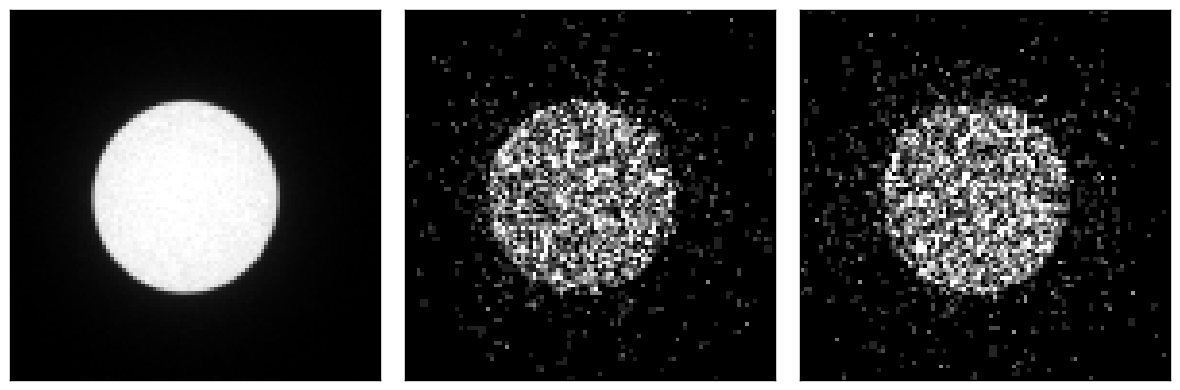

In [7]:
em.visualization.show_2d(
    [
        dc.dp_mean,
        dc.array[30,30],
        dc.array[15,15]
    ]
)

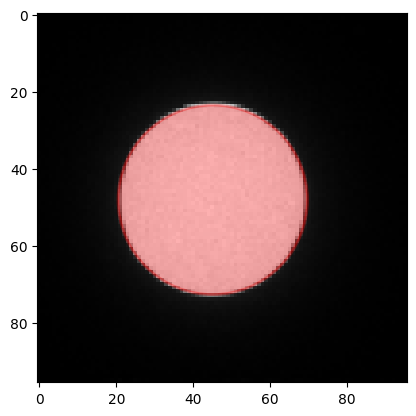

In [8]:
from quantem.core.utils.diffractive_imaging_utils import fit_probe_circle
probe_qy0, probe_qx0, probe_R = fit_probe_circle(dc.dp_mean.array, show=True)
dc.sampling[2] = PROBE_SEMIANGLE / probe_R
dc.sampling[3] = PROBE_SEMIANGLE / probe_R
dc.units[2:] = ["mrad", "mrad"]
dc.sampling[0] = FOV/SCAN_WIDTH
dc.sampling[1] = FOV/SCAN_WIDTH
dc.units[:2] = ["A", "A"]


# print(dc)

# direct ptycho

In [9]:
# Force reload the direct_ptychography module to pick up our changes
import importlib
importlib.reload(em.diffractive_imaging.direct_ptychography)

<module 'quantem.diffractive_imaging.direct_ptychography' from '/Users/macbook/repos/quantem/src/quantem/diffractive_imaging/direct_ptychography.py'>

In [ ]:
# Initiate with rotation angle in degrees
direct_ptycho = em.diffractive_imaging.direct_ptychography.DirectPtychography.from_dataset4d(
    dc,
    energy=ENERGY,
    semiangle_cutoff=PROBE_SEMIANGLE,
    aberration_coefs={'C10':10}, # start close to focus
    device="gpu",
    rotation_angle_deg=-169,
    max_batch_size=32
)


or

In [ ]:
# # Initiate with rotation angle in radians
direct_ptycho = em.diffractive_imaging.direct_ptychography.DirectPtychography.from_dataset4d(
    dc,
    energy=ENERGY,
    semiangle_cutoff=PROBE_SEMIANGLE,
    aberration_coefs={'C10':10}, # start close to focus
    device="gpu",
    rotation_angle_rad=np.deg2rad(-169), # if you prefer radians
    max_batch_size=32
)

## Quick reconstruction before optimization

100%|██████████| 1878/1878 [00:00<00:00, 72172.47it/s]


(<Figure size 400x400 with 1 Axes>, <Axes: >)

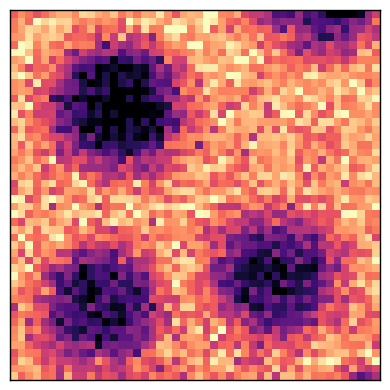

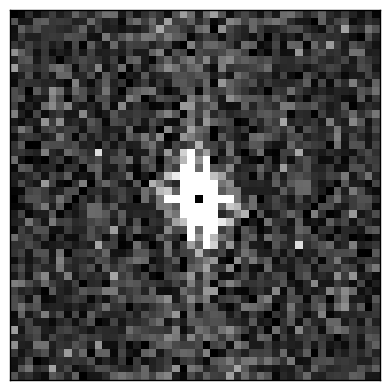

In [22]:
initial_parallax = direct_ptycho.reconstruct(
    upsampling_factor=1,
    deconvolution_kernel='quadratic',
)

# todo add plotting funciton (something like this): 
# initial_parallax = direct_ptycho.reconstruct(
    # upsampling_factor=1,
    # deconvolution_kernel='quadratic',
#).visualize(
#   show_fft = True
#)


show_2d(initial_parallax.obj, cmap = "magma")

show_2d(np.fft.fftshift(np.abs(np.fft.fft2(initial_parallax.obj))))

## direct ptycho: optimize

In [45]:
# solve for parameters 
# todo some kind of wrapper to make this more user friendly. I have suggestions but happy to hear what everyone else suggests too.

import optuna

# Option 1. Pass rotation angle in degrees (with fixed seed for reproducibility)
sampler_deg = optuna.samplers.TPESampler(seed=42)
direct_ptycho.optimize_hyperparameters(
    aberration_coefs={
        "C10":(-400,400),
        "C12":(0, 100),
        "phi12":(-np.pi/2, np.pi/2)
    },
    rotation_angle_deg=(-180, -160),
    deconvolution_kernel='quadratic',
    sampler=sampler_deg,
    n_trials=50,
)
print(f"Best params (deg): {direct_ptycho._optimized_parameters}")

Best trial: 49. Best value: 0.324776: 100%|██████████| 50/50 [00:05<00:00,  8.89it/s]



Optimized parameters: {'C10': 8.611809034675709, 'C12': 70.15604391993878, 'phi12': 0.7439307569828335, 'rotation_angle_rad': -2.824748883338925}
Best params (deg): {'C10': 8.611809034675709, 'C12': 70.15604391993878, 'phi12': 0.7439307569828335, 'rotation_angle_rad': -2.824748883338925}


In [47]:
# Option 2. Pass rotation angle in radians (with same seed - should give same result!)
sampler_rad = optuna.samplers.TPESampler(seed=42)
direct_ptycho.optimize_hyperparameters(
    aberration_coefs={
        "C10":(-400,400),
        "C12":(0, 100),
        "phi12":(-np.pi/2, np.pi/2)
    },
    rotation_angle_rad=(np.deg2rad(-180), np.deg2rad(-160)),
    deconvolution_kernel='quadratic',
    sampler=sampler_rad,
    n_trials=50,
)
print(f"Best params (rad): {direct_ptycho._optimized_parameters}")
print(f"Rotation in degrees: {np.rad2deg(direct_ptycho._optimized_parameters['rotation_angle_rad']):.2f}°")

  0%|          | 0/50 [00:00<?, ?it/s]

Best trial: 49. Best value: 0.324776: 100%|██████████| 50/50 [00:05<00:00,  8.43it/s]



Optimized parameters: {'C10': 8.611809034675709, 'C12': 70.15604391993878, 'phi12': 0.7439307569828335, 'rotation_angle_rad': -2.824748883338925}
Best params (rad): {'C10': 8.611809034675709, 'C12': 70.15604391993878, 'phi12': 0.7439307569828335, 'rotation_angle_rad': -2.824748883338925}
Rotation in degrees: -161.85°


Before proceeding, confirm above both options (rad/deg) provide the identical optimized parameters.

## Reconstruct with optimized parameters

100%|██████████| 1878/1878 [00:00<00:00, 9988.62it/s] 


(<Figure size 400x400 with 1 Axes>, <Axes: >)

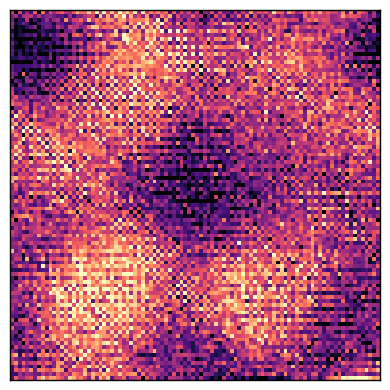

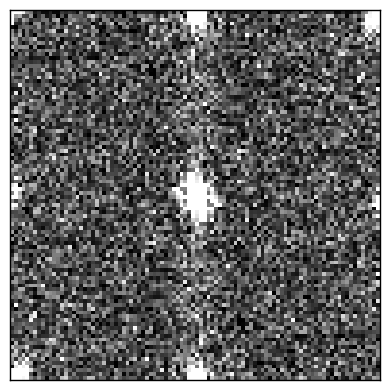

In [33]:
initial_parallax = direct_ptycho.reconstruct_with_optimized_parameters(
    upsampling_factor = 2
)

show_2d(initial_parallax.obj, cmap = "magma")
show_2d(np.fft.fftshift(np.abs(np.fft.fft2(initial_parallax.obj))))

In [48]:
direct_ptycho.fit_hyperparameters(
    bin_factors=(5,5,5,5,5,4,4,4,3,3,3,2,2,2,1,1,1,),
    deconvolution_kernel='quadratic', # use parallax for post-fit reconstruction,
    pair_connectivity = 8,
    alignment_method = "reference",
    
)

## todo: some way to force rotation to deal with 180 degree ambiguity? 

Aligning (reference): 100%|██████████| 17/17 [00:26<00:00,  1.55s/it]

Fitted parameters: {'C10': 1423.50732421875, 'C12': 38.94361877441406, 'phi12': 1.312852382659912, 'rotation_angle_rad': -0.21122045814990997}


In [49]:
# Access fitted parameters
print("Fitted rotation angle (radians):", direct_ptycho.fitted_rotation_angle_rad)
print("Fitted rotation angle (degrees):", direct_ptycho.fitted_rotation_angle_deg)
print("\nFitted aberration coefficients:", direct_ptycho.fitted_aberration_coefs)

Fitted rotation angle (radians): -0.21122045814990997
Fitted rotation angle (degrees): -12.102040798809474

Fitted aberration coefficients: {'C10': 1423.50732421875, 'C12': 38.94361877441406, 'phi12': 1.312852382659912}


100%|██████████| 1878/1878 [00:00<00:00, 10273.13it/s]


(<Figure size 400x400 with 1 Axes>, <Axes: >)

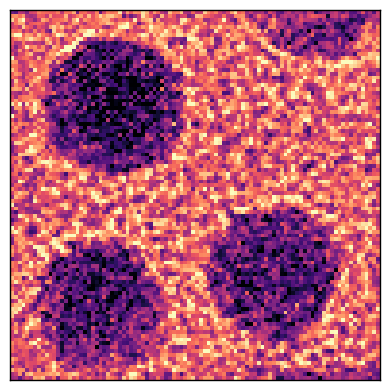

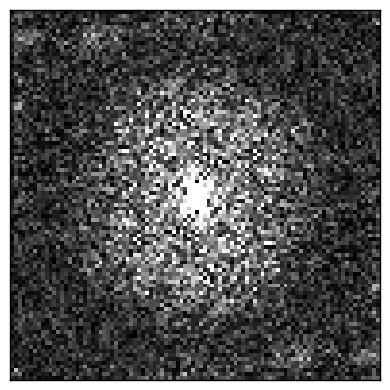

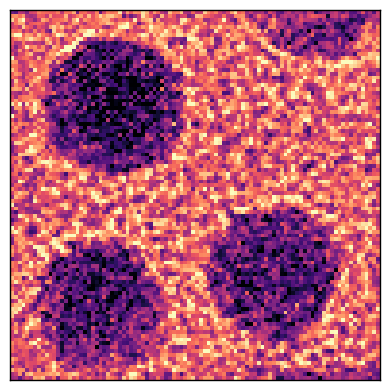

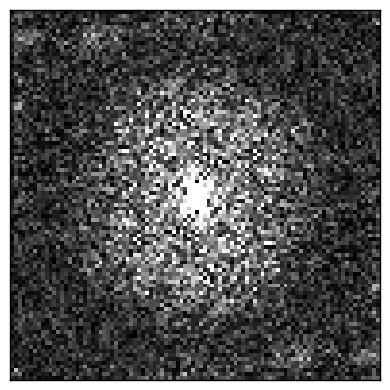

In [51]:
initial_parallax = direct_ptycho.reconstruct_with_fitted_parameters(
    upsampling_factor = 2
)

show_2d(initial_parallax.obj, cmap = "magma")


# show_2d(gaussian_filter(initial_parallax.obj,1),min=0.2, cmap = "magma")
show_2d(np.fft.fftshift(np.abs(np.fft.fft2(initial_parallax.obj))))

show_2d(initial_parallax.obj, cmap = "magma")


# show_2d(gaussian_filter(initial_parallax.obj,1),min=0.2, cmap = "magma")
show_2d(np.fft.fftshift(np.abs(np.fft.fft2(initial_parallax.obj))))

## Grid search allows either passing deg or rad for rotation angle

In [52]:
# todo plotting. it should show the whole grid of outcomes and print error/parameters. 

direct_ptycho.grid_search_hyperparameters(
    aberration_coefs={
        "C10": -348,  # Fixed value
        "C12": (0, 40, 5),  # (min, max, n_points) tuple for grid search
        "phi12": (-np.pi/2, np.pi/2, 5)  # (min, max, n_points) tuple
    },
    rotation_angle_deg=-169,  # Fixed value in degrees
    deconvolution_kernel='quadratic',
)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:02<00:00,  8.63it/s]



Best grid parameters: {'C10': -348, 'C12': np.float64(40.0), 'phi12': np.float64(-1.5707963267948966), 'rotation_angle_rad': np.float64(-2.949606435870417)}


In [53]:

direct_ptycho.grid_search_hyperparameters(
    aberration_coefs={
        "C10": -348,  # Fixed value
        "C12": (0, 40, 5),  # (min, max, n_points) tuple for grid search
        "phi12": (-np.pi/2, np.pi/2, 5)  # (min, max, n_points) tuple
    },
    rotation_angle_rad=np.deg2rad(-169),  # Fixed value in degrees
    deconvolution_kernel='quadratic',
)

100%|██████████| 25/25 [00:02<00:00,  8.94it/s]



Best grid parameters: {'C10': -348, 'C12': np.float64(40.0), 'phi12': np.float64(-1.5707963267948966), 'rotation_angle_rad': np.float64(-2.949606435870417)}


# final plotting

In [19]:
max_batch_size = 32
bf_obj = direct_ptycho.reconstruct_with_optimized_parameters(
    deconvolution_kernel='none', # no deconvolution for iCOM
    use_center_of_mass_weighting=False, # default
    max_batch_size=max_batch_size,
).obj
par_obj = direct_ptycho.reconstruct_with_optimized_parameters(
    deconvolution_kernel='quadratic', # default
    use_center_of_mass_weighting=False, # default
    max_batch_size=max_batch_size,
    upsampling_factor=2
).obj
ssb_obj = direct_ptycho.reconstruct_with_optimized_parameters(
    deconvolution_kernel='full', # default
    use_center_of_mass_weighting=False, # default
    max_batch_size=max_batch_size,
    upsampling_factor=2
).obj

# 'hybrid' iCOM modalities
icom_obj = direct_ptycho.reconstruct_with_optimized_parameters(
    deconvolution_kernel='none', # no deconvolution for iCOM
    use_center_of_mass_weighting=True,
    max_batch_size=max_batch_size,
    # upsampling_factor=2
).obj

par_icom_obj = direct_ptycho.reconstruct_with_optimized_parameters(
    deconvolution_kernel='quadratic',
    use_center_of_mass_weighting=True,
    max_batch_size=max_batch_size,
    upsampling_factor=2,
    # q_highpass = 0.01
).obj
ssb_icom_obj = direct_ptycho.reconstruct_with_optimized_parameters(
    deconvolution_kernel='full', # default
    use_center_of_mass_weighting=True,
    max_batch_size=max_batch_size,
    upsampling_factor=2,
    # q_highpass = 0.01
).obj

100%|██████████| 1878/1878 [00:00<00:00, 8767.27it/s]



(<Figure size 1800x600 with 12 Axes>,
 array([[<Axes: title={'center': 'incoherent BF'}>,
         <Axes: title={'center': 'parallax approximation'}>,
         <Axes: title={'center': 'direct ptycho'}>,
         <Axes: title={'center': 'iCOM'}>,
         <Axes: title={'center': 'parallax approximation + iCOM'}>,
         <Axes: title={'center': 'direct ptycho + iCOM'}>],
        [<Axes: title={'center': 'incoherent BF'}>,
         <Axes: title={'center': 'parallax approximation'}>,
         <Axes: title={'center': 'direct ptycho'}>,
         <Axes: title={'center': 'iCOM'}>,
         <Axes: title={'center': 'parallax approximation + iCOM'}>,
         <Axes: title={'center': 'direct ptycho + iCOM'}>]], dtype=object))

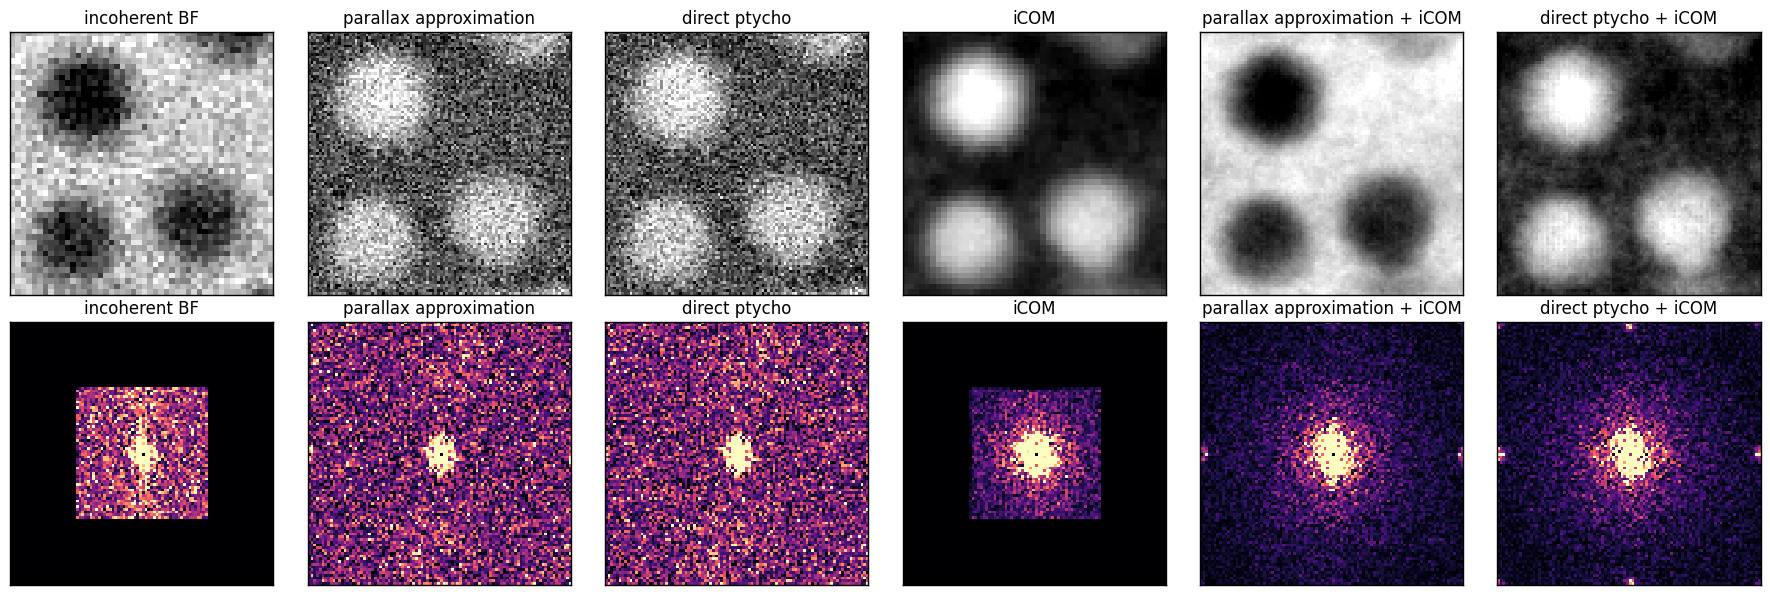

In [20]:
norm = em.visualization.NormalizationConfig(
    interval_type="manual",
    vmin=0,
    vmax=0.9
)

em.visualization.show_2d(
    [
        [
            bf_obj,
            par_obj,
            ssb_obj,
            icom_obj,
            par_icom_obj,
            ssb_icom_obj,
        ],
        [
            np.pad(np.fft.fftshift(np.abs(np.fft.fft2(bf_obj))),(icom_obj.shape[0]//2, icom_obj.shape[1]//2)),
            np.fft.fftshift(np.abs(np.fft.fft2(par_obj))),
            np.fft.fftshift(np.abs(np.fft.fft2(ssb_obj))),
            np.pad(np.fft.fftshift(np.abs(np.fft.fft2(icom_obj))),(icom_obj.shape[0]//2, icom_obj.shape[1]//2)),
            np.fft.fftshift(np.abs(np.fft.fft2(par_icom_obj))),
            np.fft.fftshift(np.abs(np.fft.fft2(ssb_icom_obj))),
        ],
    ],
    cmap=["gray","magma"],
    title=["incoherent BF","parallax approximation","direct ptycho","iCOM","parallax approximation + iCOM","direct ptycho + iCOM"],
    norm=[None,None],
    axsize=(3,3),
)